Go directly to:
- [**Start page**](https://github.com/m-guggenmos/remeta_v1/)
- [**Installation**](https://github.com/m-guggenmos/remeta_v1/blob/main/INSTALL.md)
- [**Basic Usage (this page)**](https://github.com/m-guggenmos/remeta_v1/blob/main/demo/basic_usage.ipynb)
- [**Common use cases**](https://github.com/m-guggenmos/remeta_v1/blob/main/demo/common_use_cases.ipynb)

## Basic usage

In this section, the essential settings to run a ReMeta analysis are introduced.

In [1]:
import numpy as np
import remeta_v1.remeta as remeta
import matplotlib.pyplot as plt

np.random.seed(42)  # make notebook reproducible

To specify the model, we use the `Configuration` object:

In [2]:
cfg = remeta.Configuration()

#### Specify model architecture
The architecture of the metacognitive level is characterized by three main variables:
- The fitting type which specifies whether confidence reports are thought to be suject to confidence criteria or a continuous variable resulting from a continuous process (default: `cfg.type2_fitting_type='criteria'`).
- Whether the dominant source of metacognitive noise applies to the level of readout (`cfg.type2_noise_type = 'noisy-readout'`) or the level of the confidence report (`cfg.type2_noise_type = 'noisy-readout'`). By default the toolbox assumes a noisy-report model.
- The metacognitive noise distribution, which can be naturally bound such as in the case of a beta or gamme distribution or artificially bounded via truncation.

The following table gives an overview over possible settings:

| Setting                    |                                                                                  Decsription |                                                                                                                                                                             Default | Other values                                                                            |
|:---------------------------|---------------------------------------------------------------------------------------------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------|
| `type2_fitting_type` |     *Specify whether to fit confidence criteria or treat it as a continuous output variable* |                                                                                                                                                                        `'criteria'` | `'continuous'`                                                                          |
| `type2_noise_type`         | _Specify whether metacognitive noise should be considered at the level of readout or report_ |                                                                                                                                                                    `'noisy_report'` | `'noisy_readout'`                                                                       |
 `type2_noise_dist`         |                   _Specify the type of noise distribution used to model metacognitive noise_ | `'beta'` | `'truncated_norm'`, `'gamma'`, `'truncated_gumbel'`, `'truncated_lognorm'`, `'lognorm'` |


See also some examples of choices for metacognitive noise:

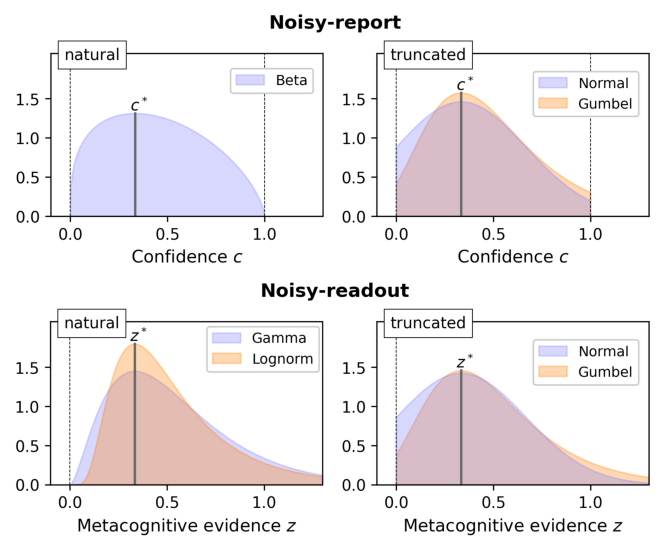

In [3]:
from matplotlib.image import imread
plt.figure(figsize=(14, 7))
plt.imshow(imread('plot_noise_models.png'))
plt.axis('off');

#### Confidence criteria
ToDo: describe how confidence criteria work in ReMeta

#### Parameter specification
In a next step, we specify the model parameters. By default, a parameter for type 1 noise and bias is enabled, as well as parameters for a type 2 noise and confidence criteria. Each parameter can either be disabled (`cfg.enable_XYZ = 0`), enabled (`cfg.enable_XYZ = 1`). Type 1 parameters can additionally be enabled in duplex mode (`cfg.enable_XYZ = 2`), which means that separate values are fitted depending on the sign of the stimulus category.

| Setting                                 | Description                                                                                                                                   | Default |
|-----------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|---------|
| `enable_type1_param_noise`              | _Sensory noise. This should be activated in all realistic<br/>settings. If set to_ `0`, _type 1 noise is set to<br/>a very small value_       | `1`     |
| `enable_type1_param_thresh`             | _Sensory threshold_                                                                                                                           | `0`     |
| `enable_type1_param_bias`               | _Sensory bias_                                                                                                                                | `1`     |
| `enable_type2_param_noise`              | _Metacognitive noise_ This should be activated in all realistic<br/>settings. If set to_ `0`, _type 2 noise is set to<br/>a very small value_ | `1`     |
| `enable_type2_param_criteria`           | _Confidence criteria (the number depends on the setting cfg.n_discrete_confidence_levels)_                                                    | `1`     |
| `enable_type2_param_evidence_bias_mult` | _Multiplicative metacognitive evidence bias_                                                                                                  | `0`     |

For illustration, we slightly deviate from the defaults by additionally enabling separate noise parameters for both stimulus categories:

In [4]:
cfg.enable_type1_param_noise = 2

#### Simulate data
To test the model, we first simulate data from a generative model that is based on the model specification above. For such an exercise, the toolbox has a method `simu_data()` which takes the `Configuration` instance as input. In addition, we have to specify the value of each parameter. The parameter names can be inferred from the `enable_XYZ` settings:

In [5]:
params_true = dict(
    type1_noise=[0.5, 0.7],
    type1_bias=-0.1,
    type2_noise=7,
    type2_criteria=[0.2, 0.2, 0.2, 0.2],
)

Note that we defined `type1_noise` as a list, such that `type1_noise[0]` and `type1_noise[1]` correspond to the type 1 noise for the negative and positive stimulus category, respectively.

Type 2 criteria are likewise defined as a list, although caution is required, as only the first entry is a criterion (the first criterion), whereas the subsequent entries specify the gap to the respective previous criterion. Thus the criteria in this case are effectively `[0.2, 0.4, 0.6, 0.8]`. These are the optimal criteria to divide the confidence space (range 0-1) into 5 bins of equal size (note the default setting `cfg.n_discrete_confidence_levels=5`).

We generate 1000 samples for a single participant. The option `x_stim_stepsize` is of minor importance here and creates stimuli between `x_stim_stepsize` and 1 in steps of `x_stim_stepsize` (i.e., for a setting of 0.25, there are four different intensities: 0.25, 0.5 0.75, 1).

In [6]:
data = remeta.simu_data(nsubjects=1, nsamples=1000, params=params_true, squeeze=True, x_stim_stepsize=0.25, cfg=cfg)

----------------------------------
Generative model:
    type1_noise: [0.5, 0.7]
    type1_bias: -0.1
    type2_noise: 7
    type2_criteria: [0.2, 0.2, 0.2, 0.2]
    type 2 model: noisy_report / beta
    Type 2 criteria (absolute): [0.2, 0.4, 0.6, 0.8]
    Criterion bias: 0
----------------------------------
Basic stats of the simulated data:
    No. subjects: 1
    No. samples: 1000
    Performance: 83.4% correct
    Choice bias: -7.6%
    Confidence: 0.64
    AUROC2: 0.71
----------------------------------


#### Visualizing the simulated data

Let's take a look at the psychometric curve:

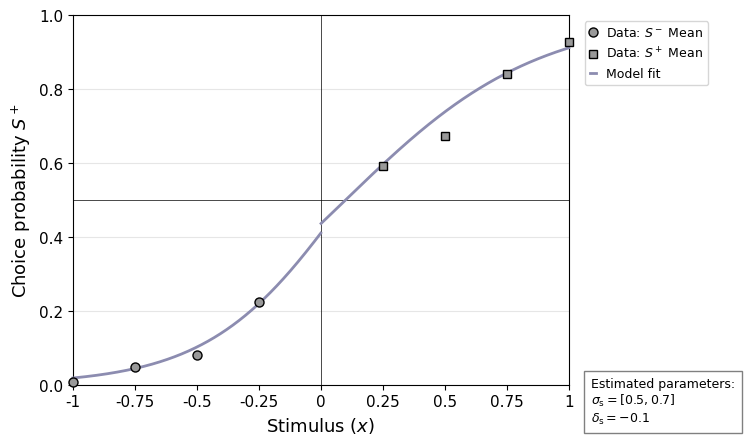

In [7]:
remeta.plot_psychometric_sim(data);

Note that the purple line is not a fit, but an (augmented) logistic function based on the true parameters. At zero, there is a discontinuity due the different type 1 noise parameters for stimulus > 0 and stimulus < 0. Moreover, the curve is shifted towards a preference for the negative stimulus category ($S^-$) due to the negative type 1 bias parameter ($S^-$ and $S^+$ are the two stimulus categories).

Next, we plot the relationship between stimulus intensity and confidence:

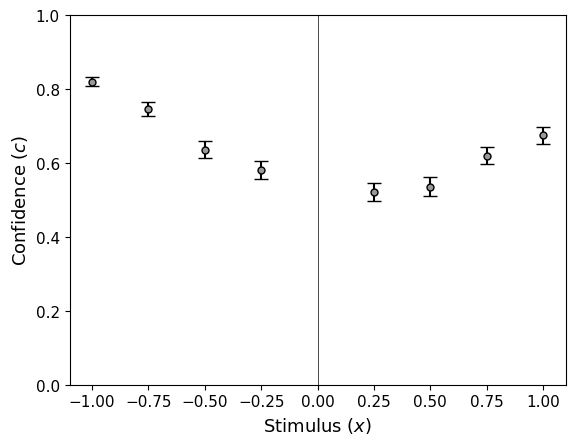

In [8]:
remeta.plot_confidence(data);

We can see that the confidence slope for negative stimuli is a bit steeper. This is because we had introduced an assymmetry in the type 1 noise between the positive and the negative stimulus category. Since we further assume an observer that computes Bayesian confidence (i.e. probability correct) based on an estimate of type 1 noise, confidence appears more 'sensitive' for the negative stimulus category (remember that we set _lower_ type 1 noise for the stimulus category $S^-$ relative to the stimulus category $S^+$).

#### Model fit
We now need to create an instance of ReMeta. Note that for illustratory purposes we pass the true parameters to the configuration as well, for later comparison.

In [9]:
cfg.true_params = params_true
rem = remeta.ReMeta(cfg=cfg)

Now, everything is in place to fit the model to the simulated data. The fit function takes three main arguments: the stimuli (in the range -1 to 1), the choices (coded as 0 and 1) and confidence ratings (normalized to the range 0..1).

In [10]:
rem.fit(data.x_stim, data.d_dec, data.c_conf)


+++ Type 1 level +++
Initial guess (neg. LL: 416.21)
    [guess] type1_noise_0: 0.5
    [guess] type1_noise_1: 0.5
    [guess] type1_bias: 0
Performing local optimization
    [final] type1_noise: [0.501, 0.682] (true: [0.5, 0.7])
    [final] type1_bias: -0.133 (true: -0.1)
Final neg. LL: 384.16
Neg. LL using true params: 384.57
Total fitting time: 0.12 secs

+++ Type 2 level +++
Initial guess (neg. LL: 1795.97)
    [guess] type2_noise: 7.301
    [guess] type2_criteria_0: 0.2
    [guess] type2_criteria_1: 0.2 = gap | criterion = 0.4
    [guess] type2_criteria_2: 0.2 = gap | criterion = 0.6
    [guess] type2_criteria_3: 0.2 = gap | criterion = 0.8
Performing local optimization
    [final] type2_noise: 7.13 (true: 7)
    [final] type2_criteria_0: 0.223 (true: 0.2)
    [final] type2_criteria_1: 0.174 (true: 0.2) = gap | criterion = 0.397 (true: 0.4)
    [final] type2_criteria_2: 0.173 (true: 0.2) = gap | criterion = 0.571 (true: 0.6)
    [final] type2_criteria_3: 0.213 (true: 0.2) = gap |

#### Inspecting the model fit

Obtain the fitting result:

In [11]:
result = rem.summary()

The parameters are stored in the attribute `model`. We've seen the estimated parameters already printed above, but they are also stored in the result object:

In [12]:
for k, v in result.model.params_type1.items():
    print(f'{k}: {v}')

type1_noise: [np.float64(0.5014270804134296), np.float64(0.6824962960612072)]
type1_bias: -0.13345247944311955


Given that the original parameter were `type1_noise=[0.5, 0.7]` and `type1_bias=-0.1`, this is not too bad. We have recovered the original parameters to some approximation. Nevertheless, the fitted parameters do not _exactly_ match our generative parameters. Since we passed the true parameters, the result object allows us to check whether this is because the optimization routine did not find the global minimum. We can find out by comparing the negative log likelihood of the true and the fitted parameters:

In [13]:
print(f"Negative log-likelihood of true type 1 parameters: {result.model.type1_model_evidence['negll_true']:.2f}")
print(f"Negative log-likelihood of fitted type 1  parameters: {result.model.type1_model_evidence['negll']:.2f}")

Negative log-likelihood of true type 1 parameters: 384.57
Negative log-likelihood of fitted type 1  parameters: 384.16


The negative log-likelihood is smaller for the fitted parameters, i.e. the likelihood is higher for the fitted than the true parameters. We can thus be confident in the obtained parameters.

Next, we take a look at the metacognitive "type 2" parameters:

In [14]:
for k, v in result.model.params_type2.items():
    print(f'{k}: {v}')

type2_noise: 7.134526658388816
type2_criteria: [np.float64(0.22302290806409844), np.float64(0.17440839256428273), np.float64(0.1733958786702537), np.float64(0.21273722861596156)]


Note that our original parameters were `type2_noise=7`, `type2_criteria=[0.2, 0.2, 0.2, 0.2]`, so this is close.

In [15]:
print(f"Negative log-likelihood of true type 2 parameters: {result.model.type2_model_evidence['negll_true']:.2f}")
print(f"Negative log-likelihood of fitted type 2 parameters: {result.model.type2_model_evidence['negll']:.2f}")

Negative log-likelihood of true type 2 parameters: 1772.67
Negative log-likelihood of fitted type 2 parameters: 1769.36


Again, the likelihhod is slightly better (i.e., lower) for the fitted parameters.

#### Visualization of the model fit

Having fit the model, we can now visualize confidence (based on the data and the fitted model) as a function of sensory decision values. For this purpose, a fitted `ReMeta` instance has a method called `plot_link_function()`:

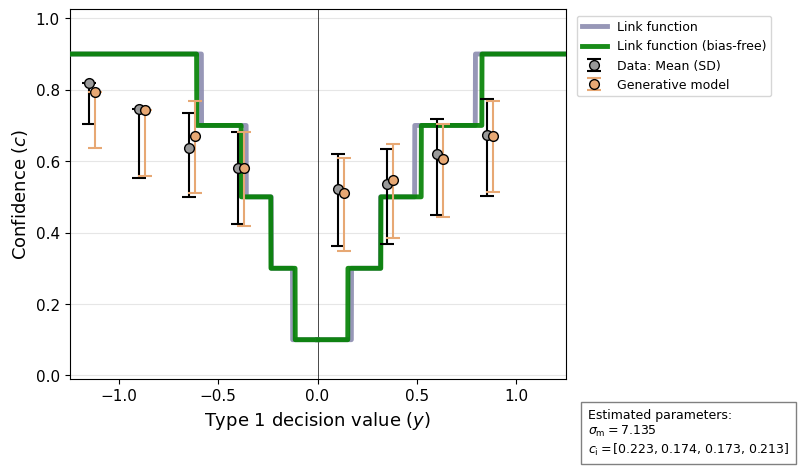

In [16]:
rem.plot_evidence_versus_confidence(plot_bias_free=True)

The large overlap between data- and model-based confidence ratings is of course not surprising, since the data were generated with a model of identical architecture and similar parameters. Green and purple lines indicate "confidence link functions", i.e. the mapping of type 1 evidence to confidence in the absence of metacognitive noise. The green line is the link function of a Bayes-optimal observer without any biases. Since this dataset represents an observer with Bayes-optimal equispaced confidence criteria, the inferred link function is likewise close top optimal.

The deviation of the link function from the actual confidence data reflects the effect of _metacognitive noise_.